In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
import tensorflow as tf
from tensorflow.keras.models import load_model
from numpy import load
from numpy import expand_dims

In [ ]:
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice

In [ ]:
# extract a single face from a given photograph
def face_preprocess(filename, required_size=(160, 160)):
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  image = image.convert('RGB')
  # resize pixels to the model size
  image = image.resize(required_size)
  face_array = asarray(image)
  return face_array

In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
  faces = list()
  # enumerate files
  for filename in listdir(directory):
    # path
    path = os.path.join(directory,filename)
    # get face
    face = face_preprocess(path)
    # store
    faces.append(face)
  return faces

In [ ]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
  x, y = list(), list()
  # enumerate folders, on per class
  for subdir in listdir(directory):
    # path
    path = os.path.join(directory,subdir) 
    # skip any files that might be in the dir
    if not isdir(path):
      continue
    # load all faces in the subdirectory
    faces = load_faces(path)
    # create labels
    labels = [subdir for _ in range(len(faces))]
    # summarize progress
    print('loaded {} faces for class : {}'.format(len(faces),subdir))
	# store
    x.extend(faces)
    y.extend(labels)
  return asarray(x), asarray(y)

In [ ]:
def get_embedding(model, face_pixels):
  face_pixels = face_pixels.astype('float32')
  mean, std = face_pixels.mean(), face_pixels.std()
  face_pixels = (face_pixels - mean) / std
  samples = expand_dims(face_pixels, axis=0)
  yhat = model.predict(samples)
  return yhat[0]

In [ ]:
base_path = 'drive/MyDrive/'
dataset_filename = 'pahlawan-dataset.npz'
embedding_filename = 'pahlawan-embedding.npz'

# uncomment if you're rizal
# model_dir = 'model/facenet_keras.h5'
# weight_dir = 'weights/facenet_keras_weights.h5'

# uncomment if you're priyo
model_dir = 'keras-facenet/model/facenet_keras.h5'
weight_dir = 'keras-facenet/weights/facenet_keras_weights.h5'

In [ ]:
# load train dataset
trainX, trainy = load_dataset(os.path.join(base_path,'phlwn/train/'))
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(os.path.join(base_path,'phlwn/val/'))
print(trainX.shape, trainy.shape)
# save arrays to one file in compressed format
savez_compressed(os.path.join(base_path, dataset_filename), trainX, trainy, testX, testy)

In [ ]:
dataset_path = os.path.join(base_path, dataset_filename)

In [ ]:
# load the face dataset to inspect 
data = load(dataset_path)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (469, 160, 160, 3) (469,) (80, 160, 160, 3) (80,)


In [ ]:
#load facenet model
model_path = os.path.join(base_path, model_dir)
weights_path = os.path.join(base_path, weight_dir)
model = load_model(model_path)
model.load_weights(weights_path)
print('Loaded Model')

Loaded Model


In [ ]:
# convert each face in the dataset to an embedding using facenet model
embeddedTrainX = []
for face_pixels in trainX:
  embedding = get_embedding(model, face_pixels)
  embeddedTrainX.append(embedding)
embeddedTrainX = asarray(embeddedTrainX)
print(embeddedTrainX.shape)

embeddedTestX = []
for face_pixels in testX:
  embedding = get_embedding(model, face_pixels)
  embeddedTestX.append(embedding)
embeddedTestX = asarray(embeddedTestX)
print(embeddedTestX.shape)

savez_compressed(os.path.join(base_path, embedding_filename), embeddedTrainX, trainy, embeddedTestX, testy)

(469, 128)
(80, 128)


In [ ]:
embedding_path = os.path.join(base_path, embedding_filename)

In [ ]:
#load faces
data = load(dataset_path)
testX_faces = data['arr_2']

# load dataset
data = load(embedding_path)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

Dataset: train=469, test=80


In [ ]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=97.228, test=90.000


Predicted: Dr. Mr. Teuku H. Moehammad Hasan (11.324)
Expected: Dr. Mr. Teuku H. Moehammad Hasan


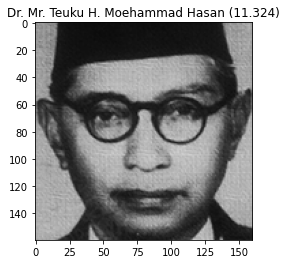

In [ ]:
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
import pickle

with open('modelheroscan.pkl', 'wb') as model_file:
  pickle.dump(model, model_file)

with open('labelheroscan.pkl', 'wb') as model_file:
  pickle.dump(out_encoder, model_file)